In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from PIL import UnidentifiedImageError

In [ ]:
!unzip /content/drive/MyDrive/siriraj-eye-dataset/Image/all_images-001.zip

In [ ]:
csv_file_path = '/content/drive/MyDrive/siriraj-eye-dataset/all_labels_processed.csv'
df = pd.read_csv(csv_file_path)

df = df.drop(columns=['camera','glaucoma_suspect','image_quality','image_quality_split', 'has_cup', 'has_disc', 'filename', 'has_cup_split', 'has_disc_split'])

old_base_path = '../dataset/siriraj-eye-dataset-2023-jan/all_images'
new_base_path = '/content/all_images'
df['path'] = df['path'].apply(lambda x: x.replace(old_base_path, new_base_path).replace('\\', '/'))

In [ ]:
df.set_index('path', inplace=False)

,dr_label,dr_label_split
path,,
/content/all_images/0.jpg,0.0,train
/content/all_images/1.jpg,0.0,train
/content/all_images/2.jpg,0.0,train
/content/all_images/3.jpg,0.0,train
/content/all_images/4.jpg,0.0,train
...,...,...
/content/all_images/515L (C).jpg,NaN,NaN
/content/all_images/596L (c).jpg,NaN,NaN
/content/all_images/544L (C).jpg,NaN,NaN


In [ ]:
df = df.dropna(subset=['dr_label'])

In [ ]:
print(df)

                              path  dr_label dr_label_split
0        /content/all_images/0.jpg       0.0          train
1        /content/all_images/1.jpg       0.0          train
2        /content/all_images/2.jpg       0.0          train
3        /content/all_images/3.jpg       0.0          train
4        /content/all_images/4.jpg       0.0          train
...                            ...       ...            ...
4612  /content/all_images/4612.jpg       1.0           test
4613  /content/all_images/4613.jpg       1.0          train
4614  /content/all_images/4614.jpg       1.0          train
4615  /content/all_images/4615.jpg       1.0           test
4616  /content/all_images/4616.jpg       1.0          train

[4617 rows x 3 columns]


In [ ]:
train_df = df[df['dr_label_split'] == 'train']
test_size = 924 / len(train_df)
train_df, val_df = train_test_split(train_df, test_size=test_size, random_state=42, stratify=train_df['dr_label'])
test_df = df[df['dr_label_split'] == 'test']
train_df.drop(columns=['dr_label_split'], inplace=True)
val_df.drop(columns=['dr_label_split'], inplace=True)
test_df.drop(columns=['dr_label_split'], inplace=True)

<ipython-input-6-e54866af1ffb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=['dr_label_split'], inplace=True)


In [ ]:
print(test_df)

                              path  dr_label
29      /content/all_images/29.jpg       0.0
30      /content/all_images/30.jpg       0.0
32      /content/all_images/32.jpg       0.0
43      /content/all_images/43.jpg       0.0
44      /content/all_images/44.jpg       0.0
...                            ...       ...
4593  /content/all_images/4593.jpg       1.0
4604  /content/all_images/4604.jpg       1.0
4607  /content/all_images/4607.jpg       1.0
4612  /content/all_images/4612.jpg       1.0
4615  /content/all_images/4615.jpg       1.0

[924 rows x 2 columns]


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (512, 512)
EPOCHS = 20

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
      img_path, label = self.dataframe.iloc[index]
      try:
        image = Image.open(img_path).convert('RGB')
      except UnidentifiedImageError:
        print(f"Skipping corrupted or unsupported image: {img_path}")
        image = Image.new('RGB', (512, 512), color='white')
      image = self.transform(image)
      return image, label


In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = val_transform

In [ ]:
train_dataset = CustomDataset(train_df, transform=train_transform)
val_dataset = CustomDataset(val_df, transform=val_transform)
test_dataset = CustomDataset(test_df, transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = models.resnet50(pretrained=True)

        for param in self.model.parameters():
            param.requires_grad = False
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.model(x)
        probas = nn.functional.softmax(x, dim=1)
        return x, probas


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [ ]:
def train(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device).long()

        optimizer.zero_grad()
        logits, probas = model(images)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(probas.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / len(data_loader), correct / total


In [ ]:
def validate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device).long()

            logits, probas = model(images)
            loss = criterion(logits, labels)

            running_loss += loss.item()
            _, predicted = torch.max(probas.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / len(data_loader), correct / total


In [ ]:
best_val_loss = 1.0
best_model_path = '/content/drive/MyDrive/siriraj-eye-dataset/dr_model.pth'
patience = 5
wait = 0

In [ ]:
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    print(f'Epoch [{epoch+1}/{EPOCHS}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    if val_loss < best_val_loss:
        print(f'New best model found! Previous best: {best_val_loss:.4f}, new best: {val_loss:.4f}. Saving model...')
        torch.save(model.state_dict(), best_model_path)
        best_val_loss = val_loss
        wait = 0
    else:
        wait += 1

    if wait > patience:
        print(f'Early stopping after {epoch+1} epochs')
        break

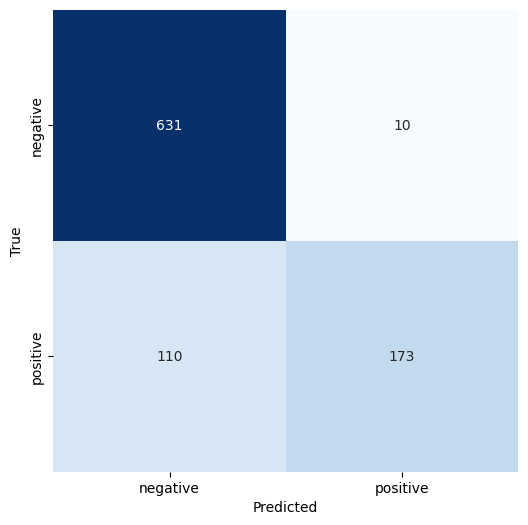

Test Accuracy: 0.8701


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
model.load_state_dict(torch.load('/content/drive/MyDrive/siriraj-eye-dataset/dr_model.pth'))
def evaluate(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device).long()

            probas, outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return correct / total

test_accuracy = evaluate(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.4f}')


In [ ]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

def predict_single_image(model, image_path, device):
    transform = Compose([
        Resize(IMG_SIZE),
        CenterCrop(IMG_SIZE),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        _, probas = model(image)
        probas = probas.cpu().numpy()
    return probas




In [ ]:
image_path = '/content/all_images/161R (2).jpg'
probas = predict_single_image(model, image_path, device)
print(f'Negative: {probas[0][0]:.2f}, Positive: {probas[0][1]:.2f}')